In [ ]:
!pip install mltu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.5 MB/s eta 0:00:00
  Created wheel for qqdm: filename=qqdm-0.0.7-py3-none-any.whl size=6466 sha256=d0f9a7d06a1b0ebf05f137f4f6768f668951c0d6dbf7e0cc580bfd9f3e5b9224
  Stored in directory: /root/.cache/pip/wheels/40/1a/56/5dccdea123a172661eb65c8c29fde4567dbda2b72b5fc5893a
Successfully built qqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import os
from datetime import datetime

from mltu.configs import BaseModelConfigs

class ModelConfigs(BaseModelConfigs):
    def __init__(self):
        super().__init__()
        self.model_path = os.path.join("/content/drive/MyDrive/project sem4/Models", datetime.strftime(datetime.now(), "%Y%m%d%H%M"))
        self.vocab = ""
        self.height = 96
        self.width = 1408
        self.max_text_length = 0
        self.batch_size = 32
        self.learning_rate = 0.0005
        self.train_epochs = 1
        self.train_workers = 20

In [ ]:
from keras import layers
from keras.models import Model

from mltu.tensorflow.model_utils import residual_block


def train_model(input_dim, output_dim, activation="leaky_relu", dropout=0.2):

    inputs = layers.Input(shape=input_dim, name="input")

    # normalize images here instead in preprocessing step
    input = layers.Lambda(lambda x: x / 255)(inputs)

    x1 = residual_block(input, 32, activation=activation, skip_conv=True, strides=1, dropout=dropout)

    x2 = residual_block(x1, 32, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x3 = residual_block(x2, 32, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x4 = residual_block(x3, 64, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x5 = residual_block(x4, 64, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x6 = residual_block(x5, 128, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x7 = residual_block(x6, 128, activation=activation, skip_conv=True, strides=1, dropout=dropout)

    x8 = residual_block(x7, 128, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x9 = residual_block(x8, 128, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    squeezed = layers.Reshape((x9.shape[-3] * x9.shape[-2], x9.shape[-1]))(x9)

    blstm = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(squeezed)
    blstm = layers.Dropout(dropout)(blstm)

    blstm = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(blstm)
    blstm = layers.Dropout(dropout)(blstm)

    output = layers.Dense(output_dim + 1, activation="softmax", name="output")(blstm)

    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
!pip install tf2onnx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 17.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding, ImageShowCV2
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage

from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CERMetric, WERMetric


import os
from tqdm import tqdm

# Must download and extract datasets manually from https://fki.tic.heia-fr.ch/databases/download-the-iam-handwriting-database to Datasets\IAM_Sentences
sentences_txt_path = os.path.join("/content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/ascii.zip (Unzipped Files)/sentences.txt")
sentences_folder_path = os.path.join("/content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)")

dataset, vocab, max_len = [], set(), 0
words = open(sentences_txt_path, "r").readlines()
for line in tqdm(words):
    if line.startswith("#"):
        continue

    line_split = line.split(" ")
    if line_split[2] == "err":
        continue

    folder1 = line_split[0][:3]
    folder2 = "-".join(line_split[0].split("-")[:2])
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip("\n")

    # replace "|" with " " in label
    label = label.replace("|", " ")

    rel_path = os.path.join(sentences_folder_path, folder1, folder2, file_name)
    if not os.path.exists(rel_path):
        print(f"File not found: {rel_path}")
        continue

    dataset.append([rel_path, label])
    vocab.update(list(label))
    max_len = max(max_len, len(label))

# Create a ModelConfigs object to store model configurations
configs = ModelConfigs()

# Save vocab and maximum text length to configs
configs.vocab = "".join(vocab)
configs.max_text_length = max_len
configs.save()

# Create a data provider for the dataset
data_provider = DataProvider(
    dataset=dataset,
    skip_validation=True,
    batch_size=configs.batch_size,
    data_preprocessors=[ImageReader(CVImage)],
    transformers=[
        ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
        LabelIndexer(configs.vocab),
        LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
)

# Split the dataset into training and validation sets
train_data_provider, val_data_provider = data_provider.split(split = 0.9)

# Augment training data with random brightness, rotation and erode/dilate
train_data_provider.augmentors = [
    RandomBrightness(),
    RandomErodeDilate(),
    RandomSharpen(),
    ]

# Creating TensorFlow model architecture
model = train_model(
    input_dim = (configs.height, configs.width, 3),
    output_dim = len(configs.vocab),
)

# Compile the model and print summary
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=configs.learning_rate),
    loss=CTCloss(),
    metrics=[
        CERMetric(vocabulary=configs.vocab),
        WERMetric(vocabulary=configs.vocab)
        ],
    run_eagerly=False
)
model.summary(line_length=110)

# Define callbacks
earlystopper = EarlyStopping(monitor="val_CER", patience=20, verbose=1, mode="min")
checkpoint = ModelCheckpoint(f"{configs.model_path}/model.h5", monitor="val_CER", verbose=1, save_best_only=True, mode="min")
trainLogger = TrainLogger(configs.model_path)
tb_callback = TensorBoard(f"{configs.model_path}/logs", update_freq=1)
reduceLROnPlat = ReduceLROnPlateau(monitor="val_CER", factor=0.9, min_delta=1e-10, patience=5, verbose=1, mode="auto")
model2onnx = Model2onnx(f"{configs.model_path}/model.h5")

# Train the model
model.fit(
    train_data_provider,
    validation_data=val_data_provider,
    epochs=configs.train_epochs,
    callbacks=[earlystopper, checkpoint, trainLogger, reduceLROnPlat, tb_callback, model2onnx],
    workers=configs.train_workers
)

# Save training and validation datasets as csv files
train_data_provider.to_csv(os.path.join(configs.model_path, "train.csv"))
val_data_provider.to_csv(os.path.join(configs.model_path, "val.csv"))

  0%|          | 34/16777 [00:02<19:02, 14.66it/s]

File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/a01/a01-000x/a01-000x-s00-00.png
File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/a01/a01-000x/a01-000x-s00-01.png
File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/a01/a01-000x/a01-000x-s00-02.png
File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/a01/a01-000x/a01-000x-s01-00.png
File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/a01/a01-000x/a01-000x-s01-01.png
File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/a01/a01-000x/a01-000x-s01-02.png
File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/a01/a01-000x/a01-000x-s01-03.png


  0%|          | 68/16777 [00:03<09:12, 30.24it/s]

File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/a01/a01-003x/a01-003x-s01-03.png
File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/a01/a01-003x/a01-003x-s02-01.png
File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/a01/a01-003x/a01-003x-s02-02.png


  3%|▎         | 507/16777 [00:12<05:09, 52.58it/s]

File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/a01/a01-068u/a01-068u-s00-01.png
File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/a01/a01-068u/a01-068u-s00-02.png
File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/a01/a01-068u/a01-068u-s01-02.png
File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/a01/a01-068u/a01-068u-s01-03.png
File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/a01/a01-068u/a01-068u-s02-00.png
File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/a01/a01-068u/a01-068u-s02-01.png
File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/a01/a01-068u/a01-068u-s02-02.png
File not found: /content/dr

 73%|███████▎  | 12170/16777 [05:19<01:47, 43.01it/s]

File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/k07/k07-059a/k07-059a-s01-01.png
File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/k07/k07-059a/k07-059a-s01-02.png
File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/k07/k07-059a/k07-059a-s02-00.png
File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/k07/k07-059a/k07-059a-s02-01.png
File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/k07/k07-059a/k07-059a-s02-06.png


 73%|███████▎  | 12180/16777 [05:19<01:46, 43.14it/s]

File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/k07/k07-063a/k07-063a-s02-00.png


 73%|███████▎  | 12189/16777 [05:19<01:49, 41.80it/s]

File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/k07/k07-067a/k07-067a-s01-00.png
File not found: /content/drive/MyDrive/project sem4/Datasets/IAM_Sentences/sentences.zip (Unzipped Files)/k07/k07-067a/k07-067a-s08-00.png


100%|██████████| 16777/16777 [06:54<00:00, 40.50it/s]
INFO:DataProvider:Skipping Dataset validation...


Model: "model"
______________________________________________________________________________________________________________
 Layer (type)                    Output Shape                     Param #    Connected to                     
 input (InputLayer)              [(None, 96, 1408, 3)]            0          []                               
                                                                                                              
 lambda (Lambda)                 (None, 96, 1408, 3)              0          ['input[0][0]']                  
                                                                                                              
 conv2d (Conv2D)                 (None, 96, 1408, 32)             896        ['lambda[0][0]']                 
                                                                                                              
 batch_normalization (BatchNorm  (None, 96, 1408, 32)             128        ['conv2d[0][0]']    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


396/396 [==============================] - 19237s 48s/step - loss: 231.9792 - CER: 1.2921 - WER: 1.4405 - val_loss: 110.5925 - val_CER: 1.0000 - val_WER: 1.0000 - lr: 5.0000e-04


Label: HELLO SHREYA
Prediction:  mece snern


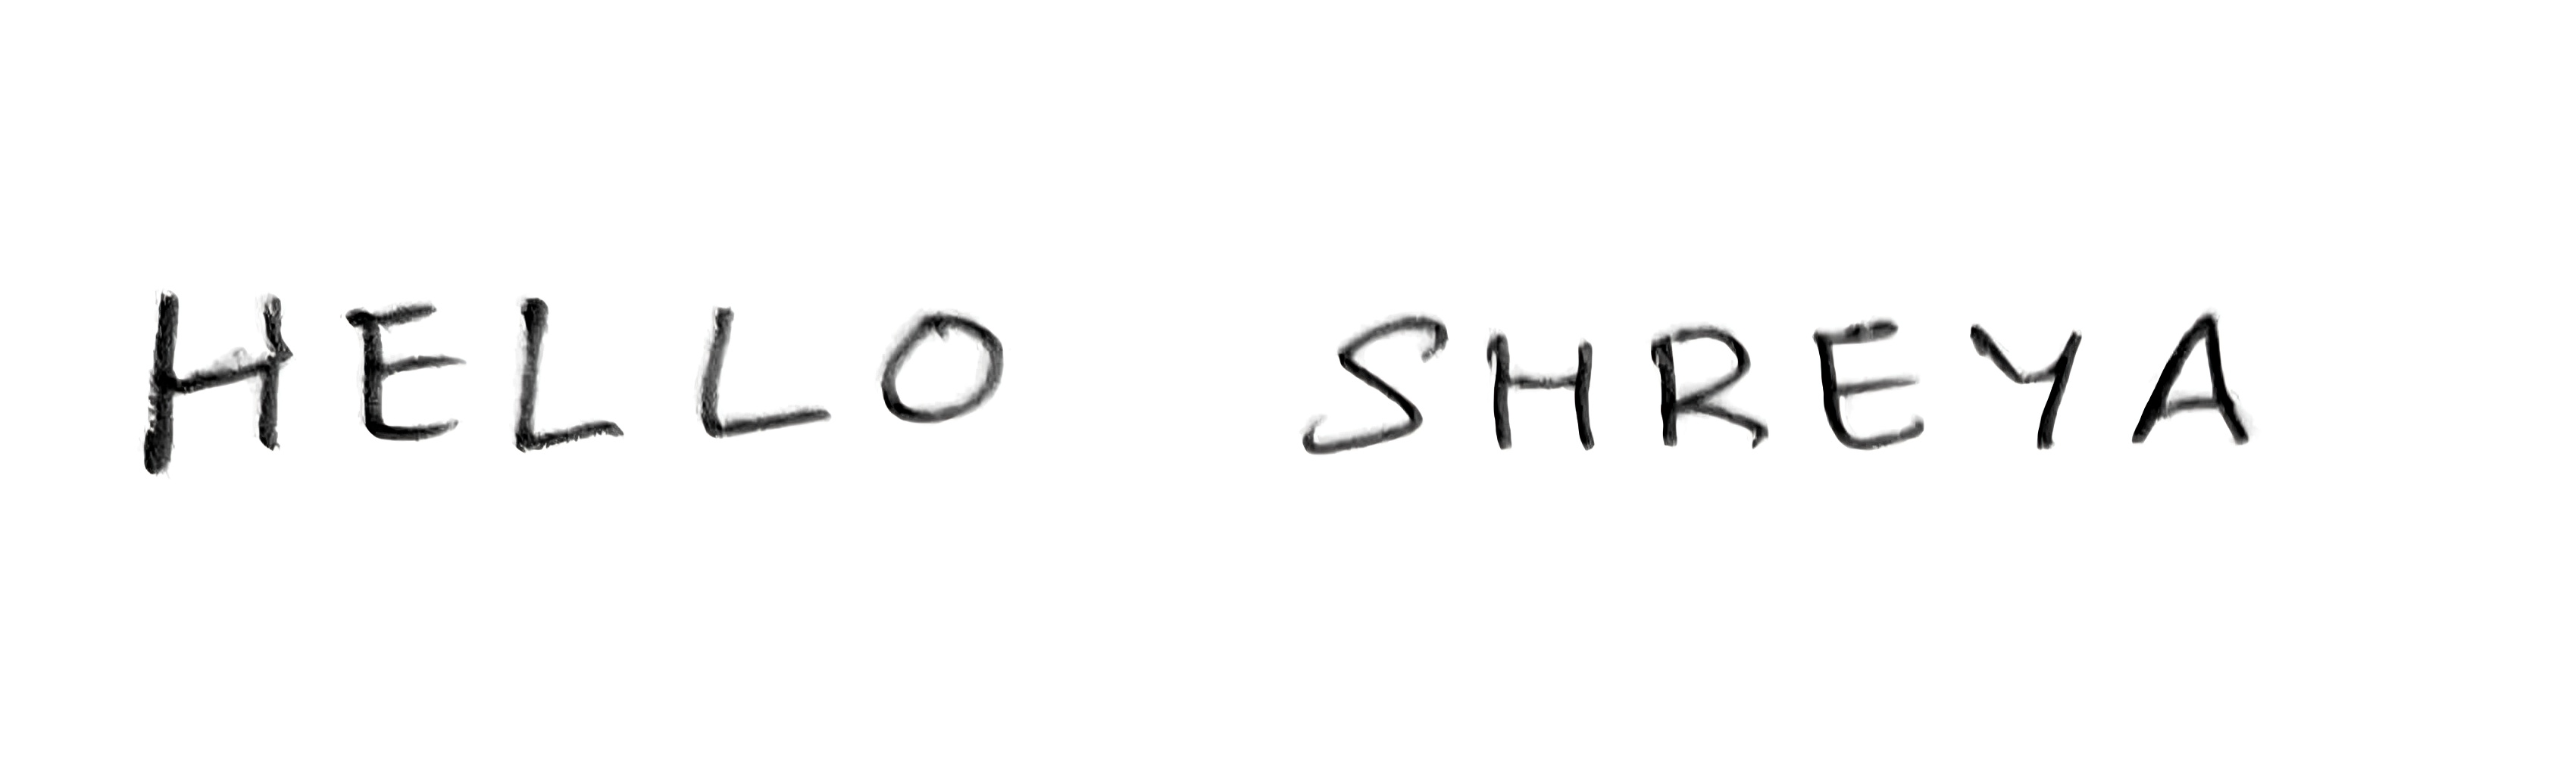

CER:  0.9166666666666666
WER:  1.0


In [ ]:
import cv2
import typing
import numpy as np
from google.colab.patches import cv2_imshow

from mltu.inferenceModel import OnnxInferenceModel
from mltu.utils.text_utils import ctc_decoder, get_cer, get_wer
from mltu.transformers import ImageResizer

class ImageToWordModel(OnnxInferenceModel):
    def __init__(self, char_list: typing.Union[str, list], *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.char_list = char_list

    def predict(self, image: np.ndarray):

        image = ImageResizer.resize_maintaining_aspect_ratio(image, *self.input_shapes[0][1:3][::-1])

        image_pred = np.expand_dims(image, axis=0).astype(np.float32)

        preds = self.model.run(self.output_names, {self.input_names[0]: image_pred})[0]

        text = ctc_decoder(preds, self.char_list)[0]

        return text

if __name__ == "__main__":
    import pandas as pd
    from tqdm import tqdm
    from mltu.configs import BaseModelConfigs

    configs = BaseModelConfigs.load("/content/drive/MyDrive/project sem4/Models/202301131202/configs.yaml")

    model = ImageToWordModel(model_path="/content/drive/MyDrive/project sem4/Models/202301131202", char_list=configs.vocab)

    df = pd.read_csv("/content/drive/MyDrive/project sem4/Models/202301131202/val.csv").values.tolist()
    label = "HELLO SHREYA"
    accum_cer, accum_wer = [], []
    image = cv2.imread("/content/drive/MyDrive/test8.png".replace("\\", "/"))
    prediction_text = model.predict(image)
    cer = get_cer(prediction_text,label)
    wer = get_wer(prediction_text,label)
    print("Label:",label)
    print("Prediction: ", prediction_text)
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    print("CER: ", cer)
    print("WER: ", wer)


In [ ]:

pip install python-docx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 4.5 MB/s eta 0:00:00


In [ ]:
from docx import Document
from docx.shared import Pt
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT

def add_code_section(doc, heading, code):
    doc.add_heading(heading, level=1)
    paragraph = doc.add_paragraph()
    run = paragraph.add_run(code)
    font = run.font
    font.name = 'Courier'
    font.size = Pt(10)

output_path = '/content/Python_Code_Documentation.docx'

# Check if the document exists
if os.path.exists(output_path):
    # Open the existing document
    doc = Document(output_path)
else:
    # Create a new document
    doc = Document()
    # Add the title if creating a new document
    title = doc.add_heading('Python Code Documentation', 0)
    title.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER
    doc.save('Python_Code_Documentation.docx')
add_code_section(doc, '1. Imports', prediction_text)

